In [1]:
import os.path
os.environ["PYTORCH_USE_CUDA_DSA"] = "1"


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import torch
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import resample
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla V100S-PCIE-32GB


In [2]:
from utilites import *

In [3]:
from my_model import CustomModel, PT5_classification_model, create_dataset, load_model_

[2024-05-10 03:56:53,013] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
#os.chdir("./")
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9994"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [63]:
vdjdb = pd.read_csv('../data/vdjdb_full.txt', sep='\t', low_memory=False)
vdjdb = vdjdb[vdjdb['antigen.epitope'] != 'KLGGALQAK']

In [64]:
vdjb_alpha = vdjdb[['cdr3.alpha', 'antigen.epitope']].dropna()

In [65]:
le = MyLabelEncoder()
groups = vdjb_alpha['antigen.epitope'].value_counts().index

le.fit(groups)
# groups
# le.transform(groups)

MyLabelEncoder()

In [66]:
vdjb_alpha['antigen.epitope']= le.transform(vdjb_alpha['antigen.epitope'])
vdjb_alpha = vdjb_alpha[vdjb_alpha['antigen.epitope']<16]

In [67]:
mapping = dict(zip(le.classes_[:17], range(17)))
mapping

{'GILGFVFTL': 0,
 'NLVPMVATV': 1,
 'AVFDRKSDAK': 2,
 'RAKFKQLL': 3,
 'YLQPRTFLL': 4,
 'IVTDFSVIK': 5,
 'SSYRRPVGI': 6,
 'SPRWYFYYL': 7,
 'TFEYVSQPFLMDLE': 8,
 'SSLENFRAYV': 9,
 'GLCTLVAML': 10,
 'RLRAEAQVK': 11,
 'LLLGIGILV': 12,
 'TTDPSFLGRY': 13,
 'ELAGIGILTV': 14,
 'LLWNGPMAV': 15,
 'ASNENMETM': 16}

In [68]:
epitopes = mapping.keys()

In [70]:
alpha_data = vdjb_alpha.reset_index(drop=True)
alpha_resampl = balance_majority(alpha_data, 'antigen.epitope', max_count=1500)
alpha_test = alpha_resampl.sample(frac=0.2, random_state=42)
alpha_test['cdr3.alpha']  = alpha_test['cdr3.alpha'].apply(add_spaces)
ans = alpha_test['antigen.epitope']
alpha_test = alpha_test.drop(columns=['antigen.epitope'])
alpha_test=alpha_test.rename({'cdr3.alpha': 'sequence'}, axis=1)
alpha_test["sequence"]=alpha_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

alpha_test.head(5)

,sequence
9353,C A I G D Q T G A N N L F F
9547,C A V S D H S N N A R L M F
15422,C V V N K E D D M R F
5038,C A T F M E Y G N K L V F
10381,C A Y R V D N A R L M F


In [71]:
tock, model_re = load_model_('../models_ft/prottrans_alp_epit.pth', num_labels=16)


Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.7.layer.0.SelfAttention.q.weight', 'decoder.block.22.layer.1.EncDecAttention.o.weight', 'decoder.block.21.layer.1.EncDecAttention.o.weight', 'decoder.block.2.layer.1.EncDecAttention.k.weight', 'decoder.block.4.layer.0.SelfAttention.k.weight', 'decoder.block.22.layer.1.layer_norm.weight', 'decoder.block.8.layer.0.SelfAttention.v.weight', 'decoder.block.13.layer.2.layer_norm.weight', 'decoder.block.1.layer.2.DenseReluDense.wo.weight', 'decoder.block.19.layer.1.EncDecAttention.q.weight', 'decoder.block.2.layer.0.SelfAttention.o.weight', 'decoder.block.9.layer.0.SelfAttention.v.weight', 'decoder.block.23.layer.0.SelfAttention.o.weight', 'decoder.block.11.layer.0.SelfAttention.k.weight', 'decoder.block.3.layer.0.SelfAttention.o.weight', 'decoder.block.10.layer.0.layer_norm.weight', 'decoder.block.8.layer.1.EncDecAttention.q.weight', 'decoder.block.9.layer.2.Den

ProtT5_Classfier
Trainable Parameter: 1209207824
ProtT5_LoRA_Classfier
Trainable Parameter: 3573776



In [72]:
test_set=create_dataset(tock, list(alpha_test['sequence']),list(ans))

test_set = test_set.with_format("torch", device=device)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

model_re.eval()

predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        #add batch results(logits) to predictions
        predictions += model_re(input_ids, attention_mask=attention_mask).logits.tolist()

100%|██████████| 296/296 [00:22<00:00, 12.95it/s]


In [73]:
predictions= [item.argmax() for item in np.array(predictions)]

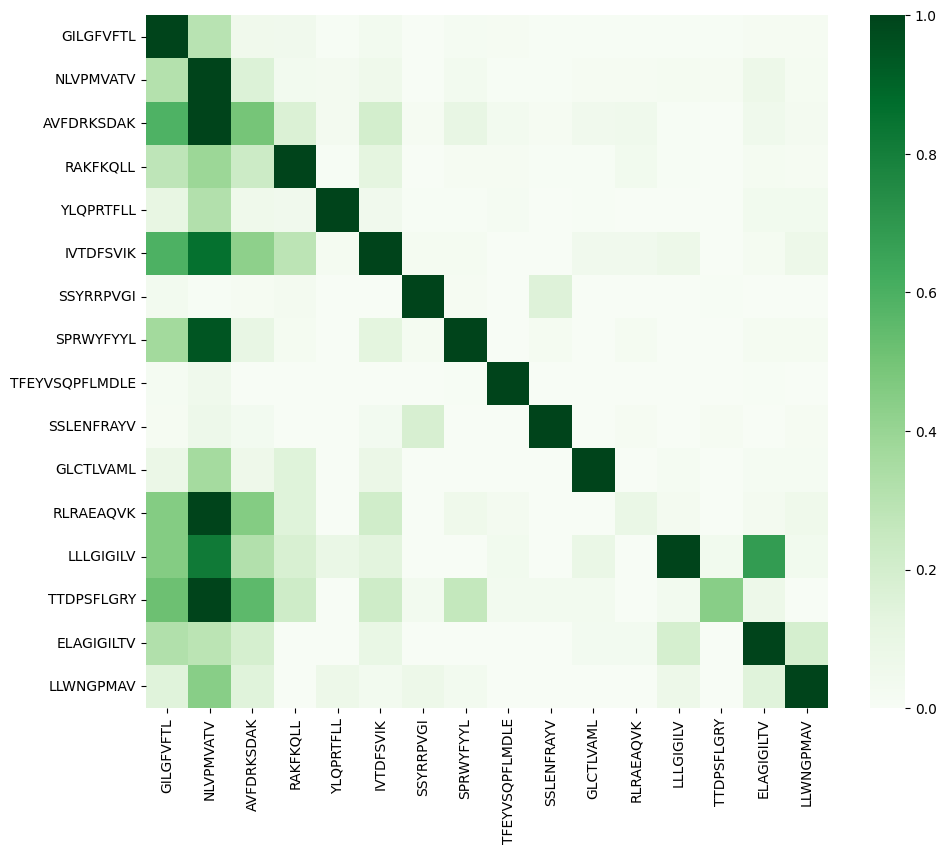

In [74]:
matrox_norm = draw_heatmap(predictions, ans, le, 16)

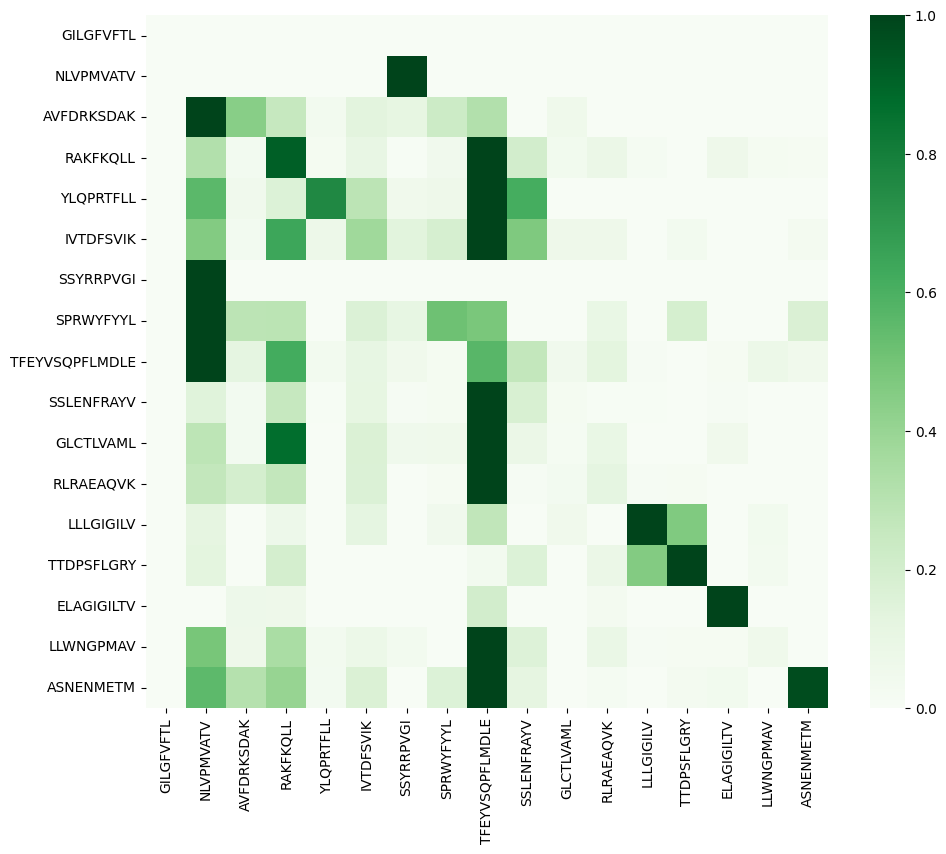

In [75]:
mist_dist_epit(matrox_norm, epitopes)

In [76]:
alpha_test_full = alpha_test.copy()
alpha_test_full['ans'] = le.inverse_transform(ans)
alpha_test_full['pred'] = le.inverse_transform(predictions)
alpha_test_full

,sequence,ans,pred
9353,C A I G D Q T G A N N L F F,GILGFVFTL,GILGFVFTL
9547,C A V S D H S N N A R L M F,RAKFKQLL,AVFDRKSDAK
15422,C V V N K E D D M R F,YLQPRTFLL,YLQPRTFLL
5038,C A T F M E Y G N K L V F,GILGFVFTL,GILGFVFTL
10381,C A Y R V D N A R L M F,AVFDRKSDAK,NLVPMVATV
...,...,...,...
5185,C A V A F G N Q F Y F,NLVPMVATV,NLVPMVATV
16511,C A A Q N Y G G S Q G N L I F,TFEYVSQPFLMDLE,TFEYVSQPFLMDLE
10316,C V V N T F S G A G S Y Q L T F,AVFDRKSDAK,AVFDRKSDAK
3947,C A Y M R S A G G T S Y G K L T F,GILGFVFTL,GILGFVFTL


In [18]:
alpha_test_full[alpha_test_full.ans == 'RLRAEAQVK']

,sequence,ans,pred
10356,C A V K D S N Y Q L I W,RLRAEAQVK,AVFDRKSDAK
7707,C A A T S G A A G N K L T F,RLRAEAQVK,NLVPMVATV
9409,C A F N Q A G T A L I F,RLRAEAQVK,NLVPMVATV
7183,C A V R E V S R L A F,RLRAEAQVK,NLVPMVATV
11872,C A V R D M D T G F Q K L V F,RLRAEAQVK,GILGFVFTL
...,...,...,...
11578,C A Y R S P L Y S G G G A D G L T F,RLRAEAQVK,AVFDRKSDAK
11130,C A A R G G Y S T L T F,RLRAEAQVK,IVTDFSVIK
11085,C A V T N Q A G T A L I F,RLRAEAQVK,AVFDRKSDAK
7677,C A V R E R D Y K L S F,RLRAEAQVK,RLRAEAQVK


In [19]:
# RLRAEAQVK is a linear peptidic epitope (epitope ID 54728) studied as part of Epstein-Barr 
# nuclear antigen 3 from Human herpesvirus 4 (Epstein Barr virus)

In [20]:
vdjdb[vdjdb['antigen.epitope'] == 'RLRAEAQVK'][['cdr3.alpha', 'cdr3.beta', 'antigen.epitope', 'antigen.gene', 'antigen.species']]

,cdr3.alpha,cdr3.beta,antigen.epitope,antigen.gene,antigen.species
23834,CAFMKHRAAGNKLTF,CASGGKVFPPYEQYF,RLRAEAQVK,EBNA3A,EBV
24056,CALGDSGAGSYQLTF,CASREIQGSGANVLTF,RLRAEAQVK,EBNA3A,EBV
24125,CAVSESYNTDKLIF,CASSQVGRPYNEQFF,RLRAEAQVK,EBNA3A,EBV
24126,CAAKARWGAQKLVF,CASSLPGQDYGYTF,RLRAEAQVK,EBNA3A,EBV
24136,CGTDSNDYKLSF,CARQPLRGANVLTF,RLRAEAQVK,EBNA3A,EBV
...,...,...,...,...,...
44053,CAAKLSDSSYKLIF,CAWREGGSEAFF,RLRAEAQVK,EBNA3A,EBV
44089,CALSEDMTTDSWGKLQF,CASSLAPSGGDEQYF,RLRAEAQVK,EBNA3A,EBV
44093,CAASPRGQGGKLIF,CASSIYVFGRGHYNEQFF,RLRAEAQVK,EBNA3A,EBV
44117,CAVRPRGDTGRRALTF,CASGGQYNEQFF,RLRAEAQVK,EBNA3A,EBV


### BETA

In [132]:
vdjb_beta = vdjdb[['cdr3.beta', 'antigen.epitope']].dropna()

In [133]:
le_beta = MyLabelEncoder()
groups = vdjb_beta['antigen.epitope'].value_counts().index

le_beta.fit(groups)
# groups
# le.transform(groups)

MyLabelEncoder()

In [134]:
vdjb_beta['antigen.epitope']= le_beta.transform(vdjb_beta['antigen.epitope'])
vdjb_beta = vdjb_beta[vdjb_beta['antigen.epitope']<16]

In [135]:
mapping_beta = dict(zip(le_beta.classes_[:16], range(16)))
mapping_beta

{'NLVPMVATV': 0,
 'GILGFVFTL': 1,
 'ELAGIGILTV': 2,
 'AVFDRKSDAK': 3,
 'RAKFKQLL': 4,
 'GLCTLVAML': 5,
 'YLQPRTFLL': 6,
 'TTPESANL': 7,
 'CTPYDINQM': 8,
 'IVTDFSVIK': 9,
 'SSYRRPVGI': 10,
 'SPRWYFYYL': 11,
 'KRWIILGLNK': 12,
 'FRDYVDRFYKTLRAEQASQE': 13,
 'TFEYVSQPFLMDLE': 14,
 'LLWNGPMAV': 15}

In [136]:
epitopes_beta = mapping_beta.keys()

In [137]:
epitopes_beta

dict_keys(['NLVPMVATV', 'GILGFVFTL', 'ELAGIGILTV', 'AVFDRKSDAK', 'RAKFKQLL', 'GLCTLVAML', 'YLQPRTFLL', 'TTPESANL', 'CTPYDINQM', 'IVTDFSVIK', 'SSYRRPVGI', 'SPRWYFYYL', 'KRWIILGLNK', 'FRDYVDRFYKTLRAEQASQE', 'TFEYVSQPFLMDLE', 'LLWNGPMAV'])

In [138]:
beta_data = vdjb_beta.reset_index(drop=True)
beta_resampl = balance_majority(beta_data, 'antigen.epitope', max_count=1500)
beta_test = beta_resampl.sample(frac=0.2, random_state=42)
beta_test['cdr3.beta']  = beta_test['cdr3.beta'].apply(add_spaces)
ans = beta_test['antigen.epitope']
beta_test = beta_test.drop(columns=['antigen.epitope'])
beta_test=beta_test.rename({'cdr3.beta': 'sequence'}, axis=1)
beta_test["sequence"]=beta_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)

beta_test.head(5)

,sequence
13158,C A S S Y G E G S Y E Q Y F
9661,C A S S Y S A S G G E Q F F
19168,C A S S I E Q Y Y E Q Y F
23524,C S V D R G S P S Y E Q Y F
15014,C A S S V R S S Y E Q Y F


In [139]:
model_re = load_model_('../models_ft/beta_tcr_bert_epit_model.pth', num_labels=16, mod_type='TCR-bert')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([16, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([16]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
model_re.n_labels

16

In [141]:
model_re.maximun_len = 40
model_re.to(device)
pred_labels = model_re.predict(beta_test['sequence'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [142]:
print("F1 score: ", f1_score(list(ans), pred_labels, average='macro'))

F1 score:  0.6178768919961157


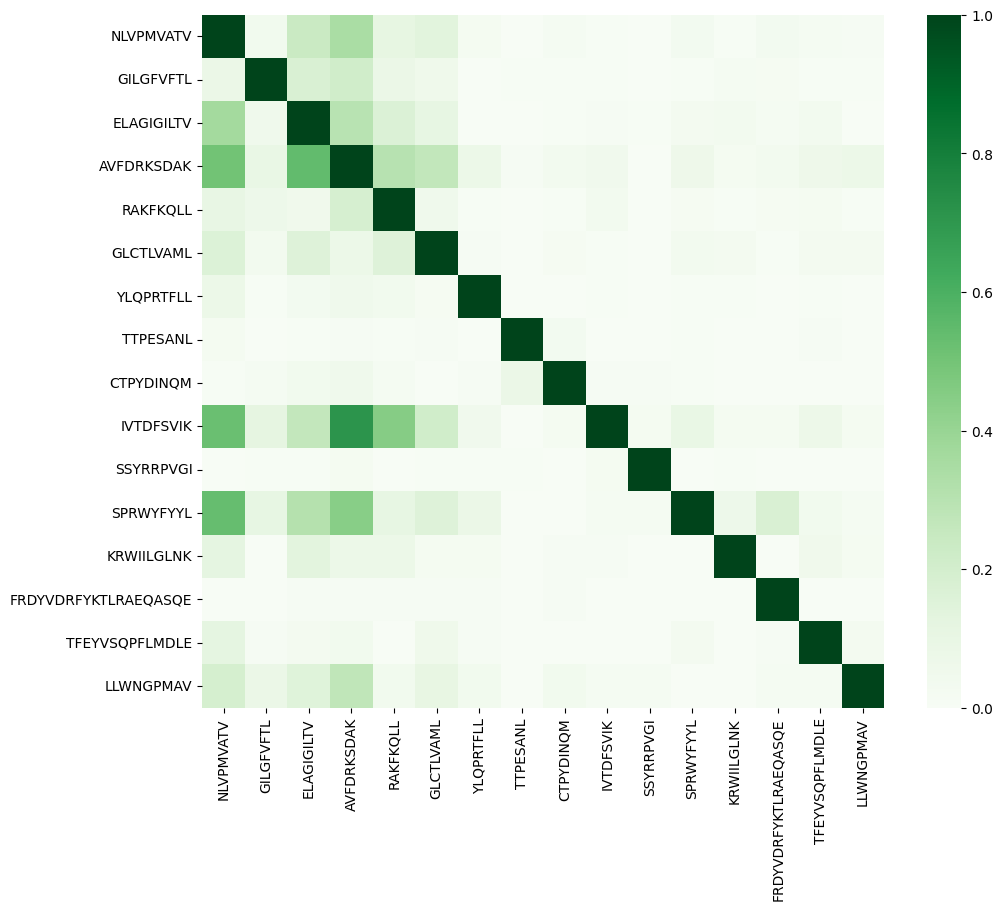

In [143]:
matrox_norm = draw_heatmap(pred_labels, ans, le_beta, 16)#, show=False)

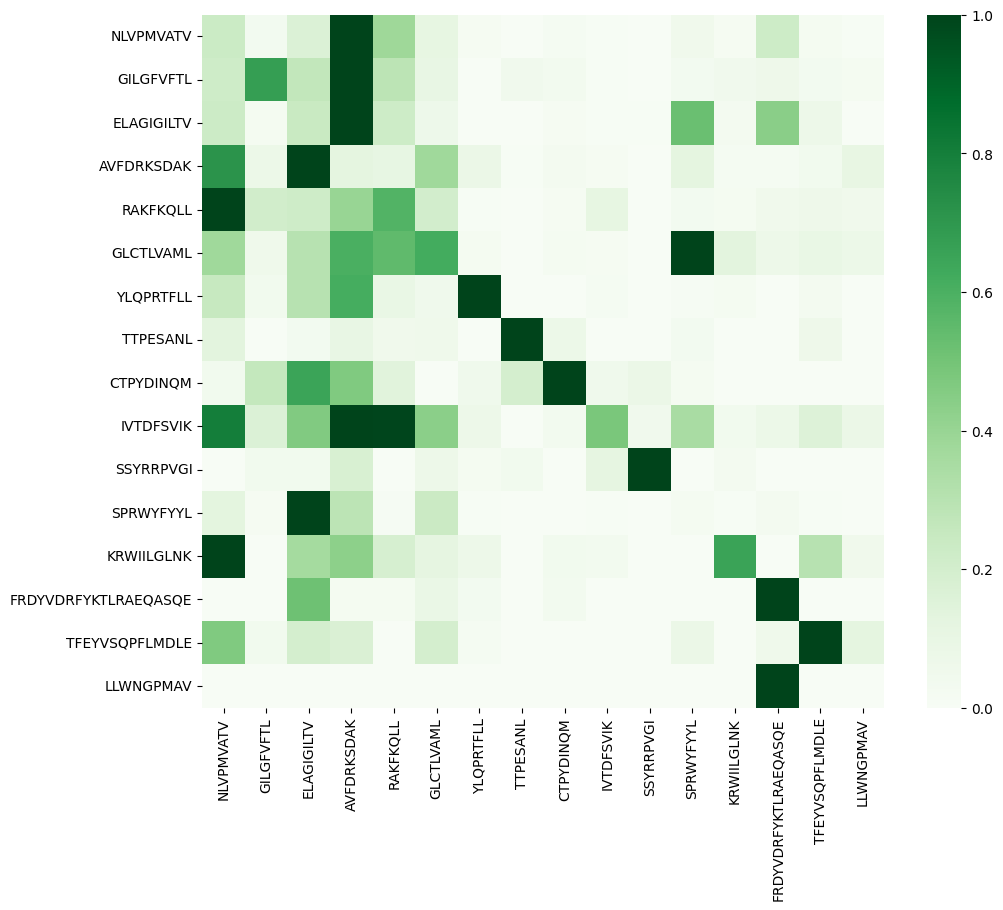

In [144]:
dist_m = mist_dist_epit(matrox_norm, epitopes_beta, rt_dist_mtr=True)

In [36]:
vdjdb = pd.read_csv('../data/vdjdb_full.txt', sep='\t', low_memory=False)

In [37]:
vdjb_short = vdjdb[['cdr3.alpha', 'cdr3.beta', 'antigen.epitope']]
vdjb_short.shape

(62177, 3)

In [38]:
vdjb_short = vdjb_short[vdjb_short['antigen.epitope'] != 'KLGGALQAK']
vdjb_short.shape

(48203, 3)

In [39]:
le = MyLabelEncoder()
groups = vdjb_short['antigen.epitope'].value_counts().index

le.fit(groups)
groups
le.transform(groups)

array([   0,    1,    2, ..., 1165, 1166, 1167])

In [40]:
vdjb_short['antigen.epitope'].value_counts()[vdjb_short['antigen.epitope'].value_counts()>500].shape[0]

19

In [41]:
vdjb_short['antigen.epitope']= le.transform(vdjb_short['antigen.epitope'])
vdjb_short

,cdr3.alpha,cdr3.beta,antigen.epitope
0,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,37
1,NaN,CASSFEAGQGFFSNQPQHF,37
2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,37
3,CAVKASGSRLT,CASSYEPGQVSHYSNQPQHF,37
4,CAYRPPGTYKYIF,CASSALASLNEQFF,37
...,...,...,...
62172,CMDEGGSNYKLTF,CASSVRSTDTQYF,131
62173,CSLYNNNDMRF,CASSLRYTDTQYF,131
62174,CALSTDSWGKLQF,CASSPGQGGDNEQFF,244
62175,CAPQGATNKLIF,CASSLGAGGQETQYF,244


In [42]:
vdjb_short = vdjb_short[vdjb_short['antigen.epitope']<19]

In [43]:
vdjb_short = vdjb_short.fillna('')
vdjb_short['cdr3aa'] = vdjb_short['cdr3.alpha'] + vdjb_short['cdr3.beta'].apply(lambda s: s[::-1])
vdjb_short.shape

(31957, 4)

In [44]:
vdjb_cdr = vdjb_short[['cdr3aa', 'antigen.epitope']]

In [46]:
# vdjb_cdr.dropna(inplace=True)
vdjb_cdr.reset_index(inplace=True, drop=True)

In [48]:
vdjb_cdr['antigen.epitope'].value_counts()

0     7830
1     7416
2     2284
3     1782
4     1536
5     1521
6     1485
7      960
8      847
9      780
10     757
11     661
12     653
13     651
14     612
15     600
16     542
17     526
18     514
Name: antigen.epitope, dtype: int64

In [49]:
vdjb_cdr = balance_majority(vdjb_cdr, 'antigen.epitope', min_count=90, max_count=1550)

In [50]:
test_dataset = vdjb_cdr.sample(frac=0.10, random_state=42)
vdjb_cdr_train = vdjb_cdr.drop(test_dataset.index)

In [51]:
vdjb_cdr_train['cdr3aa'] = vdjb_cdr_train['cdr3aa'].apply(add_spaces)
test_dataset['cdr3aa'] = test_dataset['cdr3aa'].apply(add_spaces)


In [52]:
ans = test_dataset['antigen.epitope']
test_dataset = test_dataset.drop(columns=['antigen.epitope'])



In [54]:
N_LABELS = vdjb_cdr['antigen.epitope'].nunique()
epit_mod = load_model_('../models_ft/tcr_epit.pth', mod_type='TCR-bert', num_labels=N_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at wukevin/tcr-bert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([45, 768]) in the checkpoint and torch.Size([19, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([45]) in the checkpoint and torch.Size([19]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [55]:
epit_mod.maximun_len = 40
epit_mod.to(device)

CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(26, 768, padding_idx=21)
        (position_embeddings): Embedding(64, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=

In [57]:
pred_labels = epit_mod.predict(test_dataset['cdr3aa'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/akabalina/.conda/envs/ft/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [58]:
print("F1 score: ", f1_score(list(ans), pred_labels, average='macro'))

F1 score:  0.5957076188995628


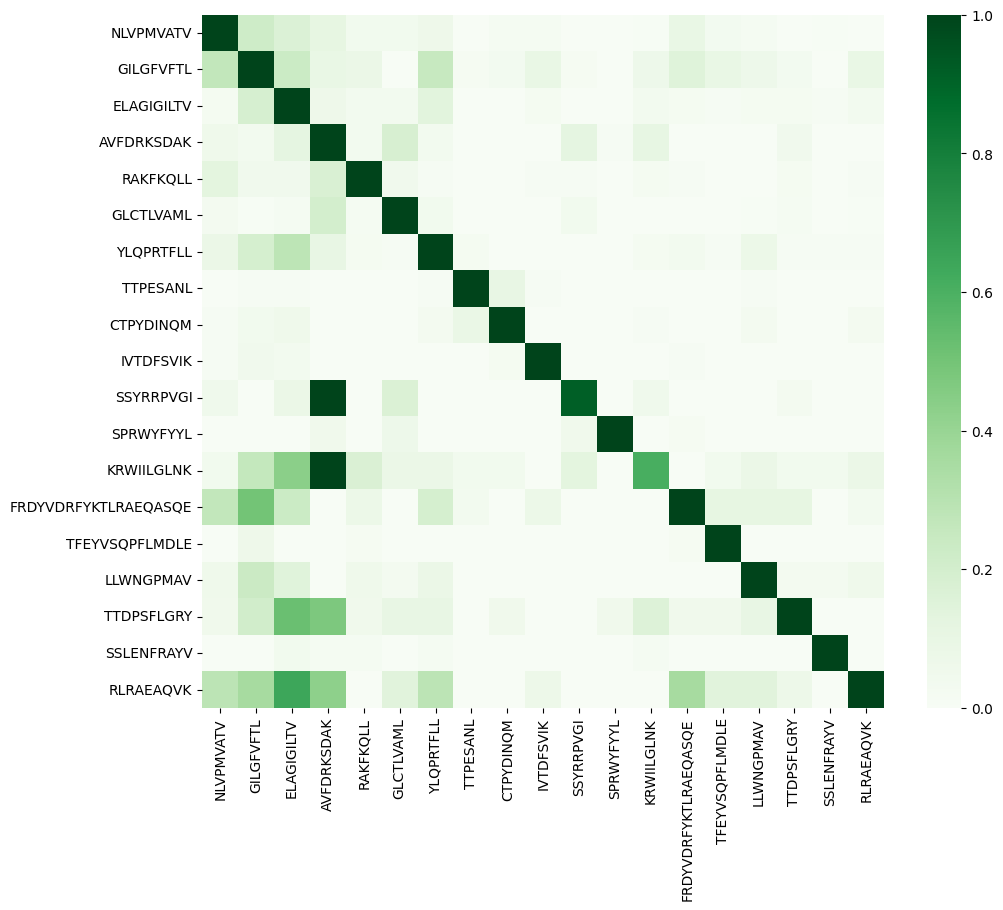

In [59]:
matrox_norm = draw_heatmap(pred_labels, ans, le_beta, 19)#, show=False)

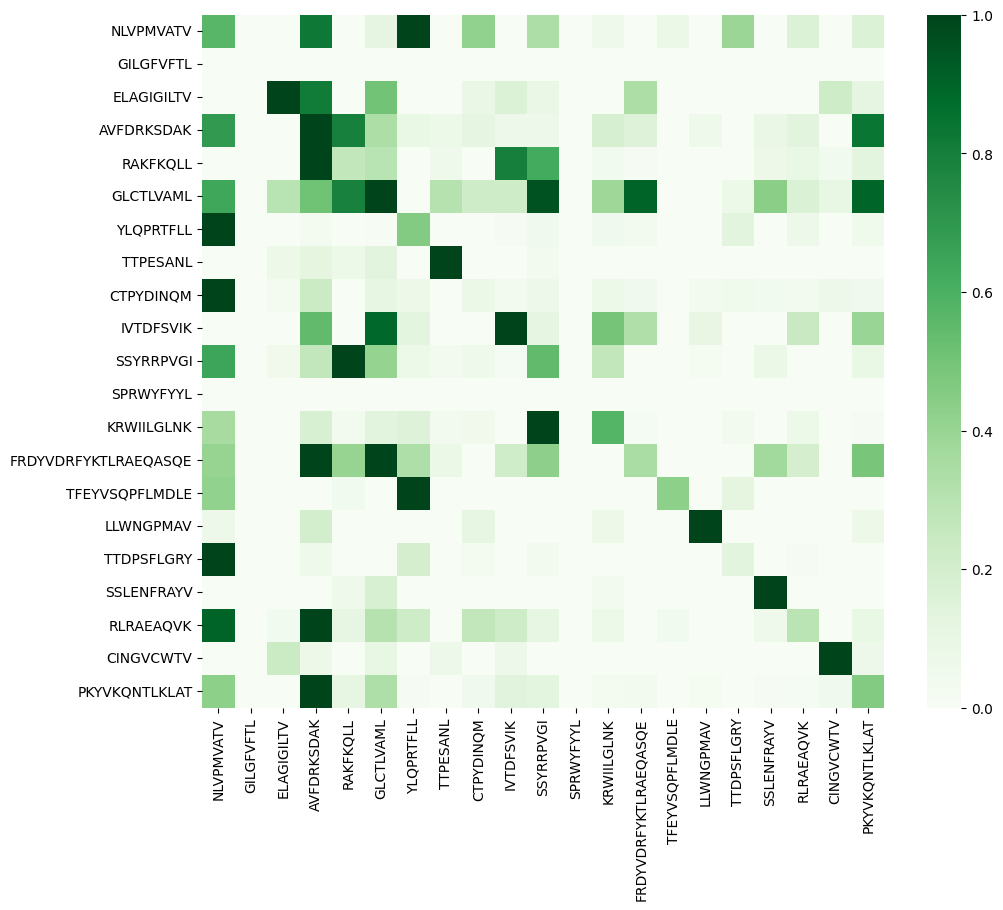

In [60]:
dist_m = mist_dist_epit(matrox_norm, epitopes_beta, rt_dist_mtr=True)